## Reading the CSV File:

In [1]:
!pip install matplotlib seaborn


In [2]:
import pandas as pd
import numpy as np 
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from prophet import Prophet
import seaborn as sns



Importing plotly failed. Interactive plots will not work.


In [3]:
customer_df = pd.read_csv(r'C:\Users\Resal\OneDrive - Alexandria University\Desktop\CustomerLoyaltyMemberDetails.csv')

### Discover the CSV file

In [4]:
#print(customer_df.head())
print(customer_df.dtypes)
customer_df.info()

Loyalty Number               int64
First Name                  object
Last Name                   object
Customer Name               object
Country                     object
Province or State           object
StateAbbr                   object
City                        object
Latitude                   float64
Longitude                  float64
Postal Code                 object
Education                   object
Location Code               object
Income                       int64
Order Year                   int64
Quarter                     object
MonthsAsMember               int64
LoyaltyStatus               object
Product Line                object
Coupon Response             object
Coupon Count                 int64
Quantity Sold                int64
Target Sales                 int64
Unit Sale Price              int64
Unit Cost                  float64
Revenue                      int64
Planned Revenue            float64
Customer Lifetime Value    float64
Loyalty Count       

### Data Cleaning

In [5]:
# missing_values = customer_df.isnull().sum()
# print(missing_values)

In [6]:
customer_df['Latitude'] = customer_df['Latitude'].fillna(0)
customer_df['Longitude'] = customer_df['Longitude'].fillna(0)


In [7]:
# change data type in postal code column 
customer_df['Postal Code'] = customer_df['Postal Code'].astype(str)


In [8]:
# Consistency in Text Fields:
customer_df['First Name'] = customer_df['First Name'].str.strip().str.title()
customer_df['Country'] = customer_df['Country'].str.strip().str.upper()


In [9]:
#check data ranges and values 
customer_df = customer_df[(customer_df['Income'] > 0) & (customer_df['Income'] < 1000000)]  


In [10]:
customer_df.loc[:, 'Quarter'] = customer_df['Quarter'].str.upper()


## Create Dimension and fact 

In [11]:
dimension_date = customer_df[['Order Year']].drop_duplicates().copy()
dimension_date['Year'] = dimension_date['Order Year']
dimension_date['Quarter'] = pd.to_datetime(dimension_date['Order Year'], format='%Y').dt.quarter
dimension_date['Date_Key'] =dimension_date.apply(lambda row: hash((row['Year'],row['Quarter'])),axis=1)
dimension_date=dimension_date.reset_index(drop=True)
print(dimension_date)

   Order Year  Year  Quarter             Date_Key
0        2019  2019        1 -4235165980016625795
1        2020  2020        1 -1431046616687094568
2        2021  2021        1 -3868104463427340261
3        2017  2017        1  1910731917746369552
4        2018  2018        1 -8844137421911236927
5        2022  2022        1 -6734124687364681123
6        2016  2016        1 -3541059351233650372


In [12]:
# Dimension Product
dimension_product = customer_df[['Product Line']].drop_duplicates().copy()
dimension_product['Product_ID'] =dimension_product.apply(lambda row: hash(row['Product Line']),axis=1)
dimension_product=dimension_product.reset_index(drop=True)
dimension_product

,Product Line,Product_ID
0,Photography,926805983054363481
1,Computers and Home Office,-376853786098793635
2,Kitchen Appliances,943299621954572997
3,TV and Video Gaming,-6375750858210226484
4,Smart Electronics,-1247783352606187425


In [13]:
# Dimension Customer
dimension_customer =customer_df[['First Name','Last Name','Customer Name', 'Education', 'Income', 'Loyalty Number']].drop_duplicates().copy()
dimension_customer['Customer_ID'] = dimension_customer.apply(lambda row: hash((row['Customer Name'], row['Loyalty Number'])), axis=1)
# Remove the index and reset to default integer index
dimension_customer=dimension_customer.reset_index(drop=True)
dimension_customer

,First Name,Last Name,Customer Name,Education,Income,Loyalty Number,Customer_ID
0,Mina,Smida,Mina Smida,Bachelor,82877,100018,-7402788326615808618
1,Sadie,Straseskie,Sadie Straseskie,High School or Below,16645,100055,4891132773702175903
2,Rheba,Stonum,Rheba Stonum,Bachelor,93752,100119,7140000914628820705
3,Soo,Schier,Soo Schier,Master,24910,100124,4831086324437960181
4,Guillermina,Tradup,Guillermina Tradup,Master,26802,100171,7220568530924839518
...,...,...,...,...,...,...,...
47209,Michaele,Ohaver,Michaele Ohaver,Bachelor,52926,999913,-8445803031273140409
47210,Thersa,Drullard,Thersa Drullard,Bachelor,88375,999932,7842209976027136118
47211,Pura,Dejulio,Pura Dejulio,Bachelor,21542,999940,-6552882234381742623
47212,Thomas,Croskey,Thomas Croskey,Bachelor,43276,999941,-3360458691202902268


In [14]:
# Dimension Loyalty (for loyalty-specific attributes)
dimension_loyalty = customer_df[['Loyalty Number']].drop_duplicates().copy()
dimension_loyalty['Loyalty_ID'] = dimension_loyalty.apply(lambda x: hash(x['Loyalty Number']),axis=1)
# Remove the index and reset to default integer index
dimension_loyalty = dimension_loyalty.reset_index(drop=True)
dimension_loyalty

,Loyalty Number,Loyalty_ID
0,100018,100018
1,100055,100055
2,100119,100119
3,100124,100124
4,100171,100171
...,...,...
47209,999913,999913
47210,999932,999932
47211,999940,999940
47212,999941,999941


In [15]:
# Create Fact Table (Sales)
fact_sales = customer_df[['Order Year', 'Product Line', 'Customer Name', 'Quantity Sold', 'Revenue', 'Planned Revenue', 'Target Sales']].copy()

In [16]:
# Add foreign keys by merging fact data with dimension tables
fact_sales = fact_sales.merge(dimension_date[['Order Year', 'Date_Key']], on='Order Year', how='left')
fact_sales = fact_sales.merge(dimension_product[['Product Line', 'Product_ID']], on='Product Line', how='left')
fact_sales = fact_sales.merge(dimension_customer[['Customer Name', 'Customer_ID']], on='Customer Name', how='left')
fact_sales

,Order Year,Product Line,Customer Name,Quantity Sold,Revenue,Planned Revenue,Target Sales,Date_Key,Product_ID,Customer_ID
0,2019,Photography,Mina Smida,3,408,399.84,3,-4235165980016625795,926805983054363481,-7402788326615808618
1,2020,Photography,Mina Smida,3,408,403.92,1,-1431046616687094568,926805983054363481,-7402788326615808618
2,2021,Photography,Mina Smida,3,408,399.84,2,-3868104463427340261,926805983054363481,-7402788326615808618
3,2017,Computers and Home Office,Sadie Straseskie,7,7434,7285.32,7,1910731917746369552,-376853786098793635,4891132773702175903
4,2019,Kitchen Appliances,Rheba Stonum,3,1554,1522.92,5,-4235165980016625795,943299621954572997,7140000914628820705
...,...,...,...,...,...,...,...,...,...,...
95239,2016,TV and Video Gaming,Thomas Croskey,1,849,832.02,1,-3541059351233650372,-6375750858210226484,-3360458691202902268
95240,2018,TV and Video Gaming,Mireille Shuskey,2,444,430.68,1,-8844137421911236927,-6375750858210226484,-328674366683048768
95241,2018,TV and Video Gaming,Mireille Shuskey,2,444,426.24,3,-8844137421911236927,-6375750858210226484,-328674366683048768
95242,2021,TV and Video Gaming,Mireille Shuskey,4,888,870.24,6,-3868104463427340261,-6375750858210226484,-328674366683048768


In [17]:
# Drop original columns that have been replaced by foreign keys
fact_sales = fact_sales.drop(columns=['Product Line', 'Customer Name'])

In [18]:
fact_sales.columns

Index(['Order Year', 'Quantity Sold', 'Revenue', 'Planned Revenue',
       'Target Sales', 'Date_Key', 'Product_ID', 'Customer_ID'],
      dtype='object')

In [19]:
# Add an identifier for fact table
fact_sales['Sales_ID'] = fact_sales.apply(lambda x: hash((x['Quantity Sold'],x['Revenue'],x['Planned Revenue'],x['Target Sales'])),axis=1)
fact_sales.reset_index(drop=True)
fact_sales.columns

Index(['Order Year', 'Quantity Sold', 'Revenue', 'Planned Revenue',
       'Target Sales', 'Date_Key', 'Product_ID', 'Customer_ID', 'Sales_ID'],
      dtype='object')

In [20]:
fact_sales.columns


Index(['Order Year', 'Quantity Sold', 'Revenue', 'Planned Revenue',
       'Target Sales', 'Date_Key', 'Product_ID', 'Customer_ID', 'Sales_ID'],
      dtype='object')

In [21]:

fact_sales = fact_sales[['Sales_ID', 'Order Year','Date_Key','Product_ID', 'Customer_ID', 'Quantity Sold', 'Revenue', 'Planned Revenue', 'Target Sales']]
fact_sales


,Sales_ID,Order Year,Date_Key,Product_ID,Customer_ID,Quantity Sold,Revenue,Planned Revenue,Target Sales
0,3050943167182596033,2019,-4235165980016625795,926805983054363481,-7402788326615808618,3,408,399.84,3
1,1426399515928806523,2020,-1431046616687094568,926805983054363481,-7402788326615808618,3,408,403.92,1
2,-3456697588919402392,2021,-3868104463427340261,926805983054363481,-7402788326615808618,3,408,399.84,2
3,5686834846649607522,2017,1910731917746369552,-376853786098793635,4891132773702175903,7,7434,7285.32,7
4,3752869062517694509,2019,-4235165980016625795,943299621954572997,7140000914628820705,3,1554,1522.92,5
...,...,...,...,...,...,...,...,...,...
95239,2541251359362395976,2016,-3541059351233650372,-6375750858210226484,-3360458691202902268,1,849,832.02,1
95240,-1601782933463022474,2018,-8844137421911236927,-6375750858210226484,-328674366683048768,2,444,430.68,1
95241,8212135360401295232,2018,-8844137421911236927,-6375750858210226484,-328674366683048768,2,444,426.24,3
95242,1880929427657751546,2021,-3868104463427340261,-6375750858210226484,-328674366683048768,4,888,870.24,6


In [22]:
#  Save all the tables to CSV
dimension_date.to_csv('Dimension_Date.csv', index=False)
dimension_product.to_csv('Dimension_Product.csv', index=False)
dimension_customer.to_csv('Dimension_Customer.csv', index=False)
dimension_loyalty.to_csv('Dimension_Loyalty.csv', index=False)
fact_sales.to_csv('Fact_Sales.csv', index=False)

## Business Question 

In [23]:
# From 2016-2021, which ORDER_YEAR had the lowest QUANTITY_SO0LD for Photography products?
photography_sales = customer_df[(customer_df['Product Line'] == 'Photography') & 
                                (customer_df['Order Year'] >= 2016) & 
                                (customer_df['Order Year'] <= 2021)]
quantity_sold_per_year = photography_sales.groupby('Order Year')['Quantity Sold'].sum()
year_with_lowest_sales = quantity_sold_per_year.idxmin()
lowest_sales = quantity_sold_per_year.min()
print(f"The year with the lowest Quantity Sold for Photography products is {year_with_lowest_sales} with {lowest_sales} items sold.")

The year with the lowest Quantity Sold for Photography products is 2017 with 9008 items sold.


In [24]:
#Which PRODUCT_LINE has the highest QUANTITY_SOLD?
quantity_sold_per_product_line = customer_df.groupby('Product Line')['Quantity Sold'].sum()
product_line_with_highest_sales = quantity_sold_per_product_line.idxmax()
highest_sales = quantity_sold_per_product_line.max()
print(f"The Product Line with the highest Quantity Sold is {product_line_with_highest_sales} with {highest_sales} items sold.")



The Product Line with the highest Quantity Sold is TV and Video Gaming with 199874 items sold.


In [25]:
# Which EDUCATION of the loyalty members had the highest amount of QUANTITY_SOLD in 2020?
sales_2020 = customer_df[customer_df['Order Year'] == 2020]
quantity_sold_per_education = sales_2020.groupby('Education')['Quantity Sold'].sum()
education_with_highest_sales = quantity_sold_per_education.idxmax()
highest_sales = quantity_sold_per_education.max()
print(f"The education level with the highest Quantity Sold in 2020 is {education_with_highest_sales} with {highest_sales} items sold.")


The education level with the highest Quantity Sold in 2020 is Bachelor with 108933 items sold.


In [26]:
#What is the CUSTOMER_NAME who provided the highest REVENUE in 2022?
sales_2022 = customer_df[customer_df['Order Year'] == 2022]
revenue_per_customer = sales_2022.groupby('Customer Name')['Revenue'].sum()
customer_with_highest_revenue = revenue_per_customer.idxmax()
highest_revenue = revenue_per_customer.max()
print(f"The customer who provided the highest revenue in 2022 is {customer_with_highest_revenue} with a total revenue of {highest_revenue}.")


The customer who provided the highest revenue in 2022 is Gil Frever with a total revenue of 39339.


Forecasted Quantity Sold for Q2 2023: 239806.60000000003


C:\Users\Resal\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


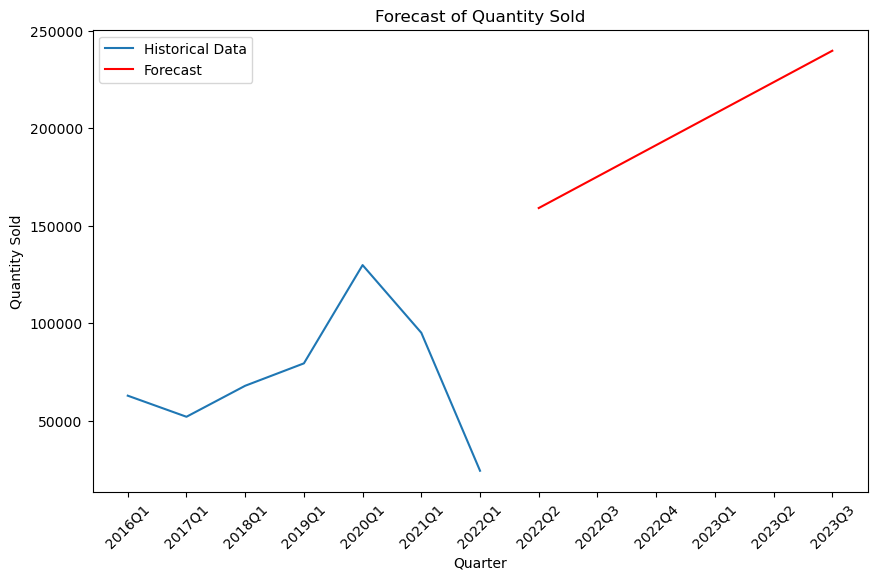

In [27]:
# Prepare the data: Convert Order Year to datetime and group by quarters
customer_df['Quarter'] = pd.to_datetime(customer_df['Order Year'], format='%Y').dt.to_period('Q')
quarterly_sales = customer_df.groupby(['Quarter'])['Quantity Sold'].sum().reset_index()
quarterly_sales.set_index('Quarter', inplace=True) 
# Add a numeric time index for regression
quarterly_sales['Time'] = np.arange(len(quarterly_sales))

# Prepare features and target variable
X = quarterly_sales[['Time']]
y = quarterly_sales['Quantity Sold']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Forecast the quantity sold for the next 6 quarters (up to Q2 2023)
future_time = np.arange(len(quarterly_sales), len(quarterly_sales) + 6).reshape(-1, 1)
forecast = model.predict(future_time)

# Output the forecast for Q2 2023
print(f"Forecasted Quantity Sold for Q2 2023: {forecast[-1]}")

# Optional: Plot the historical data along with the forecast
plt.figure(figsize=(10, 6))

# Plot the historical data
plt.plot(quarterly_sales.index.astype(str), quarterly_sales['Quantity Sold'], label='Historical Data')

# Generate future quarter labels for the forecast
future_quarters = pd.period_range(start=quarterly_sales.index[-1], periods=7, freq='Q')[1:]
plt.plot(future_quarters.astype(str), forecast, color='red', label='Forecast')

# Set labels and title
plt.xlabel('Quarter')
plt.ylabel('Quantity Sold')
plt.title('Forecast of Quantity Sold')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

14:46:25 - cmdstanpy - INFO - Chain [1] start processing
14:46:25 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Resal\miniconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(
C:\Users\Resal\miniconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\Resal\miniconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydateti

Forecasted Quantity Sold for Q2 2023: -44576.33180942058


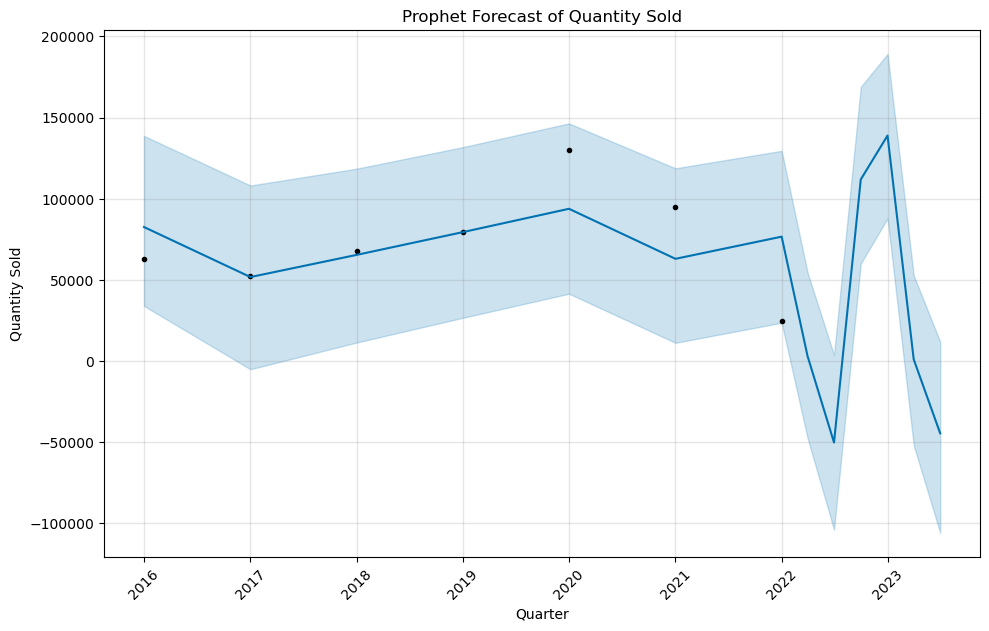

C:\Users\Resal\miniconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\Resal\miniconda3\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\Resal\miniconda3\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call 

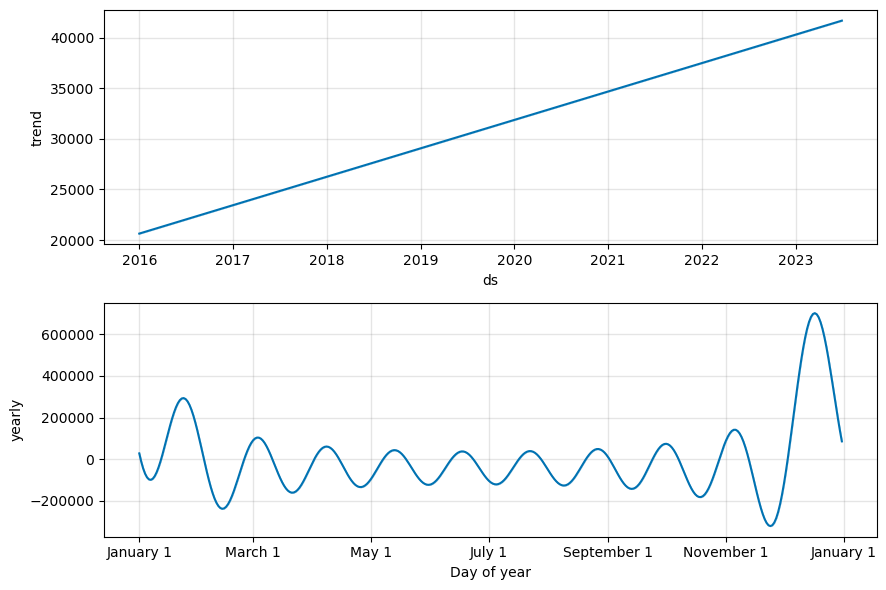

In [28]:
# Prepare the data
customer_df['Quarter'] = pd.to_datetime(customer_df['Order Year'], format='%Y').dt.to_period('Q')
quarterly_sales = customer_df.groupby(['Quarter'])['Quantity Sold'].sum().reset_index()

# Rename columns to fit Prophet's requirements
quarterly_sales['Quarter'] = quarterly_sales['Quarter'].dt.to_timestamp()  # Convert Period to Timestamp
quarterly_sales.rename(columns={'Quarter': 'ds', 'Quantity Sold': 'y'}, inplace=True)

#  Initialize and train the Prophet model
model = Prophet(interval_width=0.95)  # Setting a 95% confidence interval
model.fit(quarterly_sales)

#  Create future dataframe for the next 6 quarters
future = model.make_future_dataframe(periods=6, freq='Q')  # Forecasting 6 future quarters

# Forecast the data
forecast = model.predict(future)

#  Output forecast for Q2 2023
forecasted_value = forecast.loc[forecast['ds'] == '2023-06-30', 'yhat'].values[0]
print(f"Forecasted Quantity Sold for Q2 2023: {forecasted_value}")

#  Plot the forecast
model.plot(forecast)
plt.title('Prophet Forecast of Quantity Sold')
plt.xlabel('Quarter')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45)
plt.show()

#  Plot the forecast components (trend, seasonality)
model.plot_components(forecast)
plt.show()


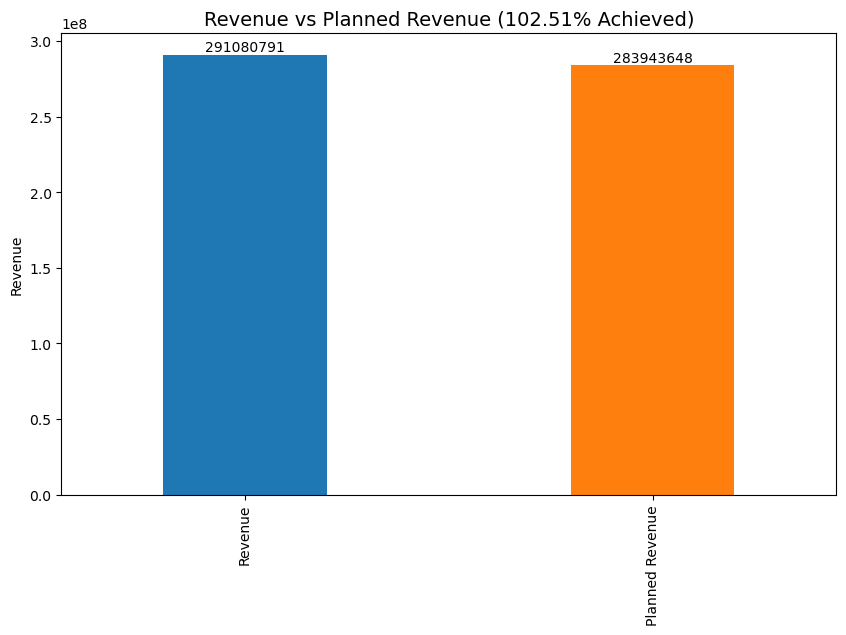

In [29]:
#  Plot Revenue vs Planned Revenue with Percentage and Values
plt.figure(figsize=(10, 6))
revenue_df = customer_df[['Revenue', 'Planned Revenue']].sum()
revenue_percent = (revenue_df['Revenue'] / revenue_df['Planned Revenue']) * 100

ax = revenue_df.plot(kind='bar', color=['#1f77b4', '#ff7f0e'], width=0.4)
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fmt='%.0f')  # Show values on the bars

plt.title(f'Revenue vs Planned Revenue ({revenue_percent:.2f}% Achieved)', fontsize=14)
plt.ylabel('Revenue')
plt.show()



C:\Users\Resal\AppData\Local\Temp\ipykernel_2344\3745193438.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Values', data=revenue_df, palette='Blues')


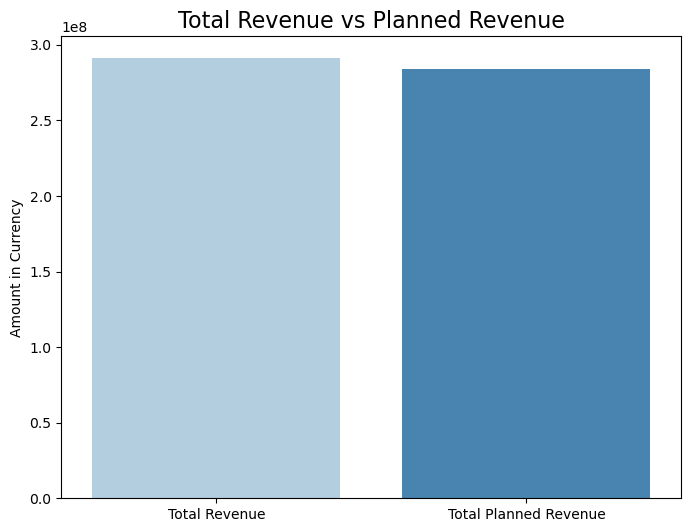

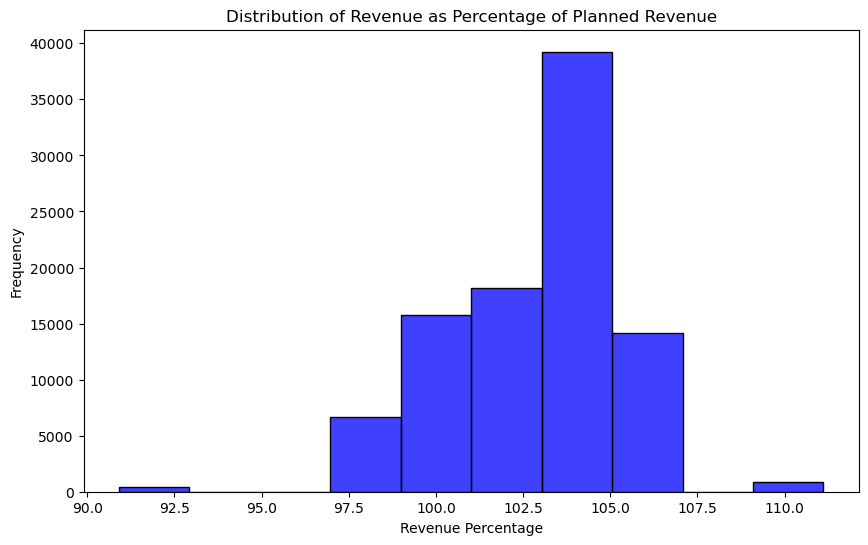

In [30]:
# Calculate total Revenue and Planned Revenue
total_revenue = fact_sales['Revenue'].sum()
total_planned_revenue = fact_sales['Planned Revenue'].sum()

# Calculate percentage of Revenue vs Planned Revenue
fact_sales['Revenue_Percentage'] = (fact_sales['Revenue'] / fact_sales['Planned Revenue']) * 100

# Bar Chart Visualization for Total Revenue vs Planned Revenue
revenue_data = {
    'Metric': ['Total Revenue', 'Total Planned Revenue'],
    'Values': [total_revenue, total_planned_revenue]
}

# Convert to DataFrame
revenue_df = pd.DataFrame(revenue_data)

# Plotting the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='Metric', y='Values', data=revenue_df, palette='Blues')

# Add title and labels
plt.title('Total Revenue vs Planned Revenue', fontsize=16)
plt.ylabel('Amount in Currency')
plt.xlabel('')

# Show plot
plt.show()

# Visualization of percentage distribution
plt.figure(figsize=(10, 6))
sns.histplot(fact_sales['Revenue_Percentage'], bins=10, color='blue')

plt.title('Distribution of Revenue as Percentage of Planned Revenue')
plt.xlabel('Revenue Percentage')
plt.ylabel('Frequency')
plt.show()

C:\Users\Resal\AppData\Local\Temp\ipykernel_2344\2754110264.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Values', data=quantity_df, palette='Greens')


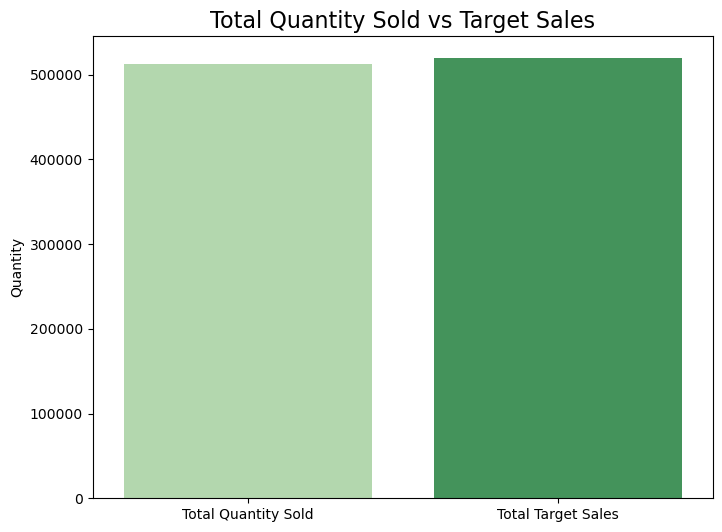

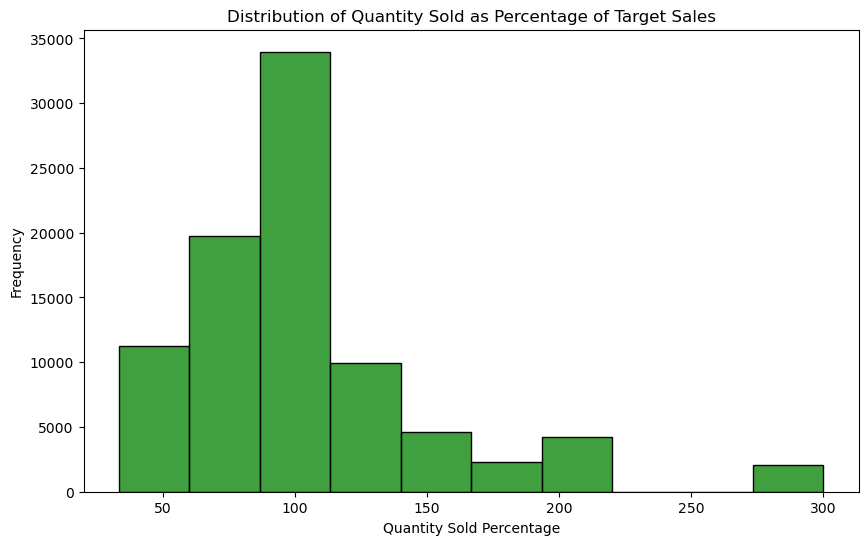

In [31]:
# Calculate total Quantity Sold and Target Sales
total_quantity_sold = fact_sales['Quantity Sold'].sum()
total_target_sales = fact_sales['Target Sales'].sum()

# Calculate percentage of Quantity Sold vs Target Sales
fact_sales['Quantity_Percentage'] = (fact_sales['Quantity Sold'] / fact_sales['Target Sales']) * 100

# Create a Bar Chart for Total Quantity Sold vs Total Target Sales
quantity_data = {
    'Metric': ['Total Quantity Sold', 'Total Target Sales'],
    'Values': [total_quantity_sold, total_target_sales]
}

# Convert to DataFrame
quantity_df = pd.DataFrame(quantity_data)

# Plotting the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='Metric', y='Values', data=quantity_df, palette='Greens')

# Add title and labels
plt.title('Total Quantity Sold vs Target Sales', fontsize=16)
plt.ylabel('Quantity')
plt.xlabel('')

# Show plot
plt.show()

# Visualization of percentage distribution of Quantity Sold vs Target Sales
plt.figure(figsize=(10, 6))
sns.histplot(fact_sales['Quantity_Percentage'], bins=10, color='green')

plt.title('Distribution of Quantity Sold as Percentage of Target Sales')
plt.xlabel('Quantity Sold Percentage')
plt.ylabel('Frequency')
plt.show()


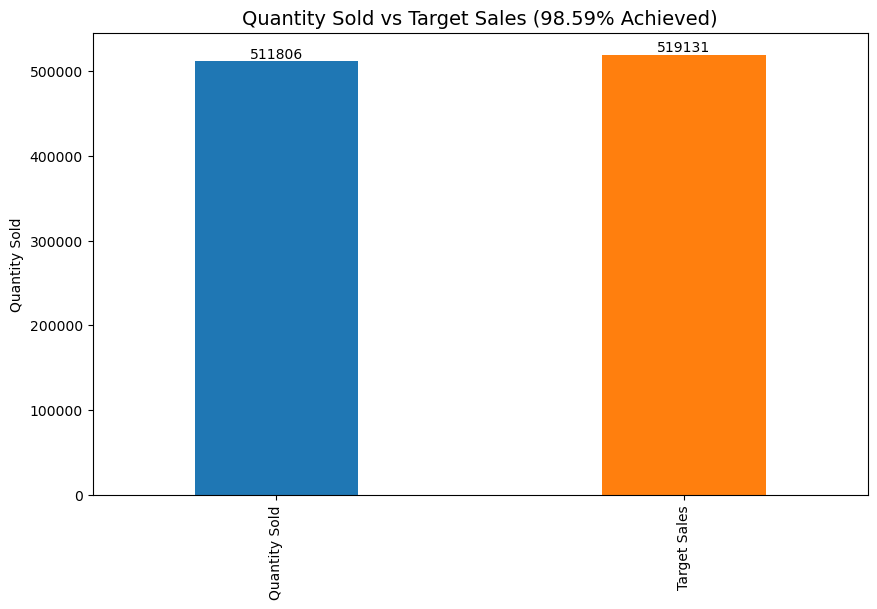

In [32]:
# Plot Quantity Sold vs Target Sales with Percentage and Values
plt.figure(figsize=(10, 6))
sales_df = customer_df[['Quantity Sold', 'Target Sales']].sum()
sales_percent = (sales_df['Quantity Sold'] / sales_df['Target Sales']) * 100

ax2 = sales_df.plot(kind='bar', color=['#1f77b4', '#ff7f0e'], width=0.4)
for i in ax2.containers:
    ax2.bar_label(i, label_type='edge', fmt='%.0f')  # Show values on the bars

plt.title(f'Quantity Sold vs Target Sales ({sales_percent:.2f}% Achieved)', fontsize=14)
plt.ylabel('Quantity Sold')
plt.show()

In [33]:
fact_sales['Order Year'] = pd.to_datetime(fact_sales['Order Year'].astype(str) + '-01-01')

# Verify the Date_Key column
print(fact_sales['Order Year'].head())

# Check the type to ensure it's datetime
print(fact_sales['Order Year'].dtype)

0   2019-01-01
1   2020-01-01
2   2021-01-01
3   2017-01-01
4   2019-01-01
Name: Order Year, dtype: datetime64[ns]
datetime64[ns]


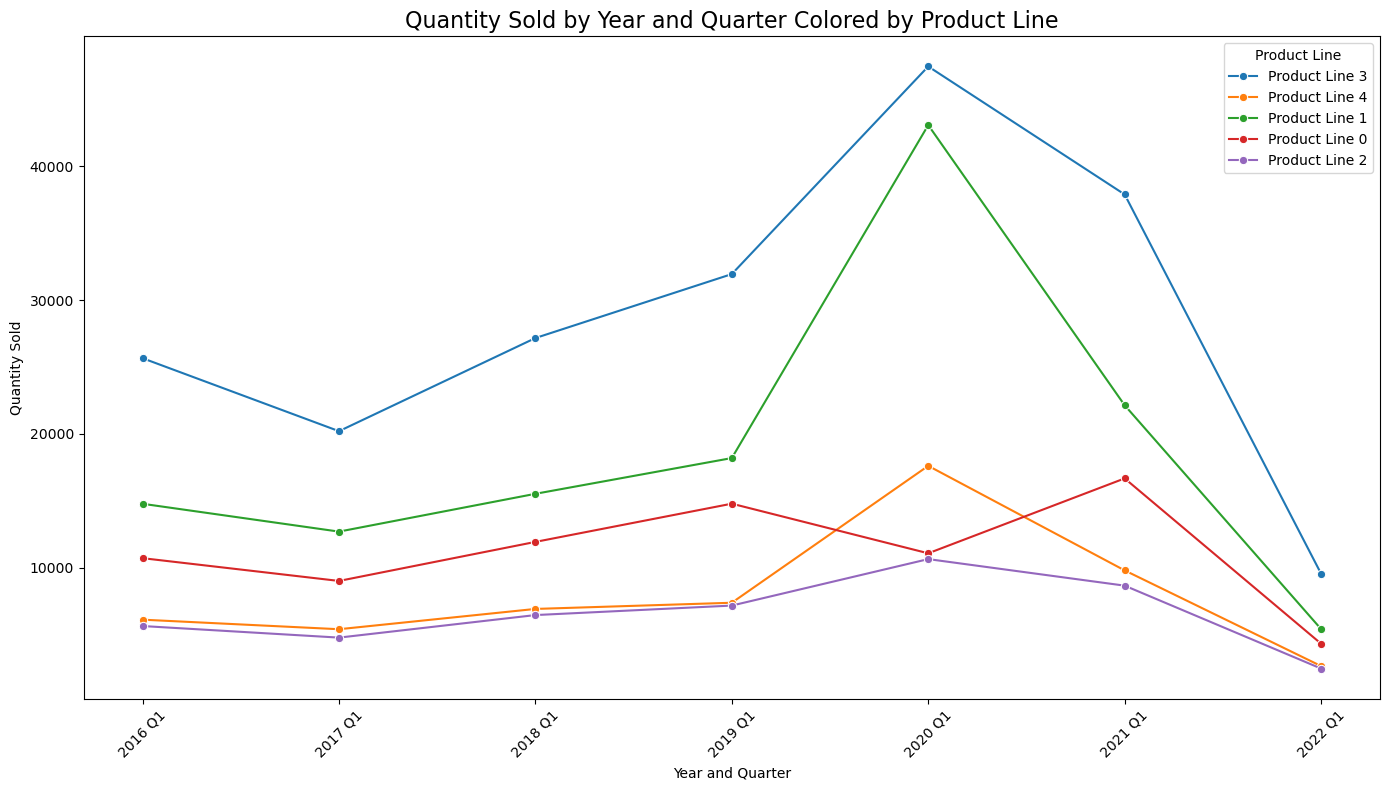

In [34]:
fact_sales['Year'] = fact_sales['Order Year'].dt.year
fact_sales['Quarter'] = fact_sales['Order Year'].dt.to_period('Q').astype(str).str.split('Q').str[1].astype(int)


# Replace this with actual dimension_product loading or creation
dimension_product = pd.DataFrame({
    'Product_ID': fact_sales['Product_ID'].unique(),
    'Product Line': ['Product Line ' + str(i) for i in range(len(fact_sales['Product_ID'].unique()))]
})

# Aggregate quantity sold by Year, Quarter, and Product_ID
quantity_by_year_quarter = fact_sales.groupby(['Year', 'Quarter', 'Product_ID']).agg({'Quantity Sold': 'sum'}).reset_index()

# Merge with dimension_product to get Product Line
quantity_by_year_quarter = quantity_by_year_quarter.merge(dimension_product[['Product_ID', 'Product Line']], on='Product_ID', how='left')

# Create a more readable format for Year and Quarter
quantity_by_year_quarter['Year_Quarter'] = quantity_by_year_quarter['Year'].astype(str) + ' Q' + quantity_by_year_quarter['Quarter'].astype(str)

# Plot Quantity Sold by Year and Quarter, colored by Product Line
plt.figure(figsize=(14, 8))
sns.lineplot(data=quantity_by_year_quarter, x='Year_Quarter', y='Quantity Sold', hue='Product Line', marker='o')

# Add title and labels
plt.title('Quantity Sold by Year and Quarter Colored by Product Line', fontsize=16)
plt.xlabel('Year and Quarter')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show plot
plt.legend(title='Product Line')
plt.tight_layout()
plt.show()

In [35]:
print(fact_sales.columns)



Index(['Sales_ID', 'Order Year', 'Date_Key', 'Product_ID', 'Customer_ID',
       'Quantity Sold', 'Revenue', 'Planned Revenue', 'Target Sales',
       'Revenue_Percentage', 'Quantity_Percentage', 'Year', 'Quarter'],
      dtype='object')


In [36]:
fact_sales

,Sales_ID,Order Year,Date_Key,Product_ID,Customer_ID,Quantity Sold,Revenue,Planned Revenue,Target Sales,Revenue_Percentage,Quantity_Percentage,Year,Quarter
0,3050943167182596033,2019-01-01,-4235165980016625795,926805983054363481,-7402788326615808618,3,408,399.84,3,102.040816,100.000000,2019,1
1,1426399515928806523,2020-01-01,-1431046616687094568,926805983054363481,-7402788326615808618,3,408,403.92,1,101.010101,300.000000,2020,1
2,-3456697588919402392,2021-01-01,-3868104463427340261,926805983054363481,-7402788326615808618,3,408,399.84,2,102.040816,150.000000,2021,1
3,5686834846649607522,2017-01-01,1910731917746369552,-376853786098793635,4891132773702175903,7,7434,7285.32,7,102.040816,100.000000,2017,1
4,3752869062517694509,2019-01-01,-4235165980016625795,943299621954572997,7140000914628820705,3,1554,1522.92,5,102.040816,60.000000,2019,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95239,2541251359362395976,2016-01-01,-3541059351233650372,-6375750858210226484,-3360458691202902268,1,849,832.02,1,102.040816,100.000000,2016,1
95240,-1601782933463022474,2018-01-01,-8844137421911236927,-6375750858210226484,-328674366683048768,2,444,430.68,1,103.092784,200.000000,2018,1
95241,8212135360401295232,2018-01-01,-8844137421911236927,-6375750858210226484,-328674366683048768,2,444,426.24,3,104.166667,66.666667,2018,1
95242,1880929427657751546,2021-01-01,-3868104463427340261,-6375750858210226484,-328674366683048768,4,888,870.24,6,102.040816,66.666667,2021,1


In [37]:
print(fact_sales['Order Year'].dtype)


datetime64[ns]
